## Algorithm 

The algorithm is proposed in [A Practical Algorithm for Topic Modeling with Provable Guarantees](https://arxiv.org/abs/1212.4777); the theory (of a slightly different algorithm) is proved in [Learning Topic Models - Going beyond SVD](https://arxiv.org/abs/1204.1956). I used the implementation in [pyJSMF-RAW](https://github.com/sc782/pyJSMF-RAW). 

Here I mainly investigate how the `recoverS` step (finding set of anchor words, called $S$) works in noisy setting. 


### main idea of the algorithm

Suppose the dataset is $X$, a count matrix of size $(p, n)$ (e.g. $n$ is the number of documents in a corpus; $p$ is the number of words in the dictionary). We want to do a non-negative factorization of $X \approx A W$ where $A \in R_{+}^{p, K}$ and $W \in R_{+}^{K, n}$. It's also basically the same as [topic model](https://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf?TB_iframe=true&width=370.8&height=658.8)(if we assume each document is sampled from a multinomial model), or [Poisson Matrix Factorization](https://arxiv.org/pdf/1311.1704.pdf) (if we assume each word count from a document is sampled from Poisson). An alternative paramterization (used in factor analysis) is $X^T = L F^T$ where $L = W^T$, $F = A$. 


The anchor-word based algorithm assumes for each $k \in [K]$ there exists one row in $A$ that is nonzero only in the $k$th entry. The consequences of this assumption (after scaling $X, W$ s.t. rowsums are 1) are:
- $W$ are $K$ rows of $X$ that correspond to anchor words (call them anchor rows)
- The rowspace of $X$ is in the convex hull of the $K$ anchor rows. 

Therefore to find anchor rows the problem becomes finding the extremal $K$ points that form the convex hull of rows of $X$. 


However each row of $X$ is a very bad approximation of the true underlying word probability vector (call that matrix $X^{*}$). So we instead compute from $X$ a word-word co-occurence matrix ($p \times p$) $C_{ij} := p(w_1 = i, w_2 = j)$ the probability that word $(i, j)$ appear together in a document. The algorithm is similar to previously described: after scaling rows of $C$ to sum to one (call it $\bar{C}$), we find the extremal $K$ points that form the convex hull of $\bar{C}$. The implementation uses modified Gram–Schmidt with row pivoting. 


## Experiments

- I use two simulated datasets where I know true $\bar{C}$ (can recover true anchor words correctly with true $C$). I looked at the "recovered anchor words" from estimated $\hat{\bar{C}}$, anc compare the true anchor words.  

- Also I look at how MLE does with these datasets. 

## Results

- The algorithm fails to find the right anchor words (this screws up the estimation of $A$ and $R := \frac{1}{n} W W^T$, not shown here). In contrast MLE finds anchor words correctly

* The theory requires dictionary size to be small (discard less frequent words), which I didn't do here. As a result the l1 error of the estimation of rows of $\bar{C}$ is large, mainly because of the error from less frequent words . 


In [1]:
import os
import sys
import pandas as pd
from scipy import sparse

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
import seaborn as sns
from matplotlib.colors import LogNorm
import pickle

script_dir = "../"
sys.path.append(os.path.abspath(script_dir))
from file2 import *
from factorize import *
from smallsim_functions4 import *
from misc import *
from sinkhorn import * 

np.random.seed(123)

## Experimen1: 

* I simulate a $(n, p) = (1000, 1200)$ count matrix ($n$ sample size; $p$ dictionary size). 
* There are 3 topics. For each topic ($F$ or $A$ scaled to have column sums to 1) there are $20$ top words and top words are 100 times more expressed than other words. 
* For loading ($L^T$ or $W$ scaled to have columns sum to 1) I use a logistic-normal (normals are iid).  
* Then I use a document length of $80$ and multinomial model to simulate each document. 
* The underlying model satisfies anchor-word assumption; all the anchor words are also the most frequent words
* Code for simulating: https://github.com/zihao12/pyJSMF-RAW/blob/master/smallsim_functions4.py

In [2]:
n = 1000
p = 1200 ## make this larger to increase difficulty
n_top = 20 ## number of top words in each topic
k = 3
doc_len = 80

X, Atrue, Ftrue, p0 = smallsim_independent(n = n, p = p, k = k, doc_len = doc_len, n_top = n_top)
w_idx = np.where(X.sum(axis = 0) > 0)[0]
X = X[:,w_idx]

In [3]:
%%capture
Ctrue = Ftrue[w_idx,:] @ Atrue @ Ftrue[w_idx,:].T
Strue_fit, Btrue_fit, Atrue_fit, _, _, _, _, _ = factorizeC(Ctrue, K=k, rectifier='no', optimizer='activeSet')

In [4]:
%%capture
Clong, _, _ = X2C(sparse.coo_matrix(X))
Slong_fit, Blong_fit, Along_fit, _, _, _, _, Clong = factorizeC(Clong, K=k, rectifier='AP', optimizer='activeSet')

In [5]:
Clong_bar = Clong / Clong.sum(axis = 1)[:, None]
Ctrue_bar = Ctrue / Ctrue.sum(axis = 1)[:, None]

Below is the histogram of l1 error between rows of $\bar{C}$ and $\hat{\bar{C}}$

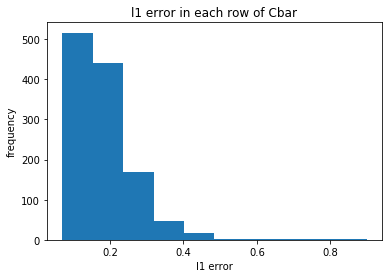

In [6]:
err_l1 = np.abs(Ctrue_bar - Clong_bar).sum(axis = 1)
plt.hist(err_l1)
plt.xlabel("l1 error")
plt.ylabel("frequency")
plt.title("l1 error in each row of Cbar")
plt.show()

### Look at  anchor rows in true $\bar{C}$ 

project rows of $\bar{C}$ to the first two singular vectors

true anchor words in true Cbar


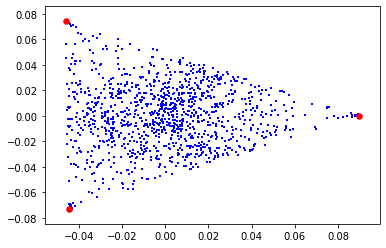

In [7]:
Cbar_proj_true = Cbar_proj(Ctrue)
print("true anchor words in true Cbar")
vis_extremal_pca(Cbar_proj_true, Strue_fit)

recovered anchor words in true Cbar


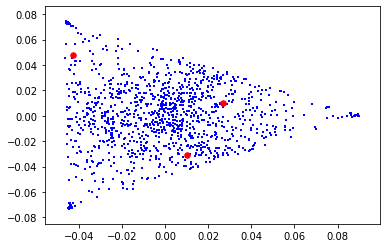

In [8]:
print("recovered anchor words in true Cbar")
vis_extremal_pca(Cbar_proj_true, Slong_fit)

### Look at anchor rows in estimated $\hat{\bar{C}}$

project rows of $\bar{C}$ to the first two singular vectors

true anchor words in estimated Cbar


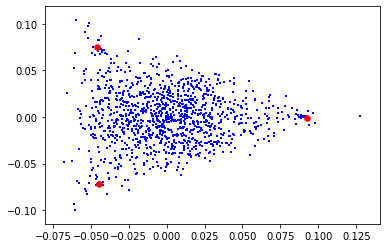

In [9]:
print("true anchor words in estimated Cbar")
Cbar_proj_long = Cbar_proj(Clong)
vis_extremal_pca(Cbar_proj_long, Strue_fit)

recovered anchor words in estimated Cbar


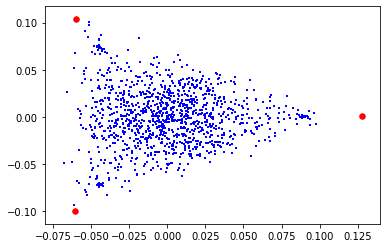

In [10]:
print("recovered anchor words in estimated Cbar")
vis_extremal_pca(Cbar_proj_long, Slong_fit)

## MLE gets the right model

I fit a Poisson Matrix Factorization model (or equivalently NMF with generalized KL divergence loss). To see MLE does correctly, I use the fitted $A, W$ to form $\hat{\bar{C}}$, and identify anchor words with this $\hat{\bar{C}}$. Turns out correct.

In [11]:
%%capture
model = NMF(n_components=k, beta_loss = 'kullback-leibler',
            solver = 'mu', 
            init='random', random_state=0)
W = model.fit_transform(X.T)
H = model.components_

Anmf = (H @ H.T) / n 
Cnmf = W @ Anmf @ W.T
Cnmf_bar = Cnmf/Cnmf.sum(axis=1)[:,None]
Cnmf_bar_pj = Cbar_proj(Cnmf)

Snmf, _, _ = findS(Cnmf_bar, k)

recovered anchor words in estimated Cbar formed by MLE fit


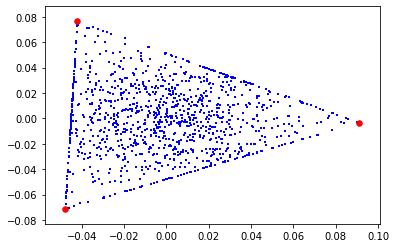

true anchor words in estimated Cbar formed by MLE fit


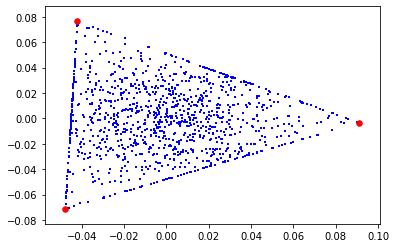

In [12]:
which_dim = [0, 1]
print("recovered anchor words in estimated Cbar formed by MLE fit")
vis_extremal_pca(Cnmf_bar_pj, Snmf, which_dim)
print("true anchor words in estimated Cbar formed by MLE fit")
vis_extremal_pca(Cnmf_bar_pj, Strue_fit, which_dim)

## Experiment 2

This is a more "realistically simulated" dataset. The original dataset $(n, p) = (3207, 8766)$ is a text dataset called [SLA](https://zihao12.github.io/ebpmf_data_analysis/data_preprocessing_sla). I first fit MLE with $K = 6$ and get $A, W$. With the $A, W$, I simulated another count matrix, and apply the anchor-word based algorithm. 

The code for simulation and fitting is https://github.com/zihao12/pyJSMF-RAW/blob/master/experiments/sla_multinomial_sim_fit.py



In [13]:
## load data
dataname = "sla"
k = 6
rate=3

datafile=f"output/fit_sim_{dataname}_fastTopics_k{k}_rate{rate}.pkl"
with open(datafile, "rb") as f:
    fitted = pickle.load(f)
    
X = fitted['X']
Lt = fitted['Ltrue'].T ## k by n
F = fitted['Ftrue']
Strue = fitted['S0']
Sfit = fitted['S']
Cfit = fitted['C']
Ctrue = F @ Lt
Ctrue = (Ctrue @ Ctrue.T) / Lt.shape[1]

## Look at estimation for $C$

Below is the histogram of l1 error between rows of $\bar{C}$ and $\hat{\bar{C}}$

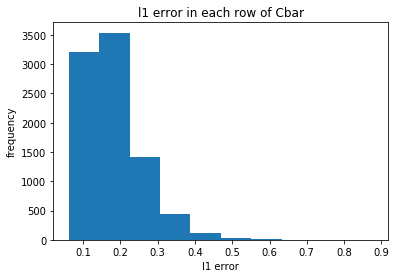

In [14]:
Ctrue_bar = Ctrue / Ctrue.sum(axis = 1)[:, None]
Cfit_bar = Cfit / Cfit.sum(axis = 1)[:, None]
err_l1 = np.abs(Cfit_bar - Ctrue_bar).sum(axis = 1)
plt.hist(err_l1)
plt.xlabel("l1 error")
plt.ylabel("frequency")
plt.title("l1 error in each row of Cbar")
plt.show()
plt.show()

## Compare geometry between $\bar{C}$ and $\hat{\bar{C}}$

Again I visualize eacg row of $\bar{C}$ and $\hat{\bar{C}}$ by projecting them to the first two singular vectors respectively. 

true anchor words in true Cbar


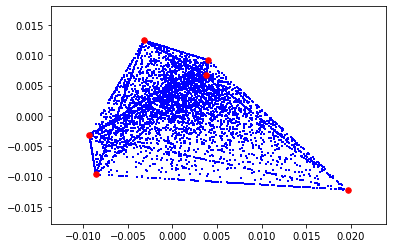

recovered anchor words in true Cbar


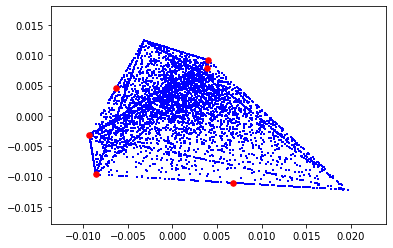

In [15]:
Cbar_proj_true = Cbar_proj(Ctrue)
print("true anchor words in true Cbar")
vis_extremal_pca(Cbar_proj_true, Strue)
print("recovered anchor words in true Cbar")
vis_extremal_pca(Cbar_proj_true, Sfit)

true anchor words in estimated Cbar


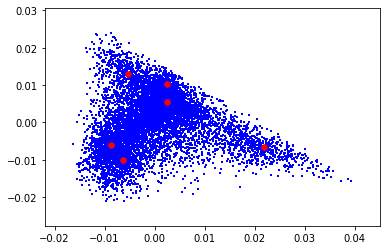

recovered anchor words in estimated Cbar


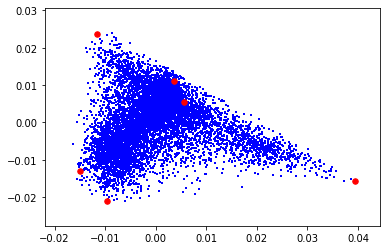

In [16]:
print("true anchor words in estimated Cbar")
Cbar_proj_fit = Cbar_proj(Cfit)
vis_extremal_pca(Cbar_proj_fit, Strue)

print("recovered anchor words in estimated Cbar")
vis_extremal_pca(Cbar_proj_fit, Sfit)

## Still MLE gets correct anchor words


In [17]:
%%capture
model = NMF(n_components=k, beta_loss = 'kullback-leibler',
            solver = 'mu', 
            init='random', random_state=0)
W = model.fit_transform(X.T)
H = model.components_

Anmf = (H @ H.T) / X.shape[0]
Cnmf = W @ Anmf @ W.T
Cnmf_bar = Cnmf/Cnmf.sum(axis=1)[:,None]
Cnmf_bar_pj = Cbar_proj(Cnmf)

Snmf, _, _ = findS(Cnmf_bar, k)

recovered anchor words in true Cbar


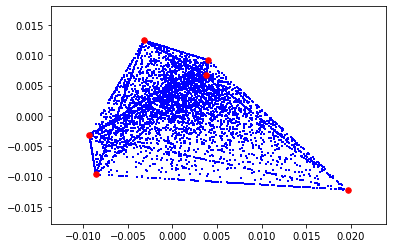

true anchor words in est Cbar


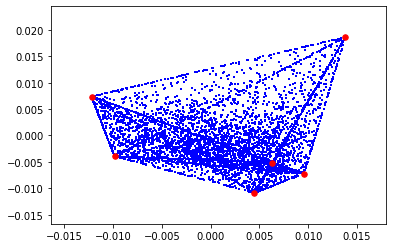

recovered anchor words in est Cbar


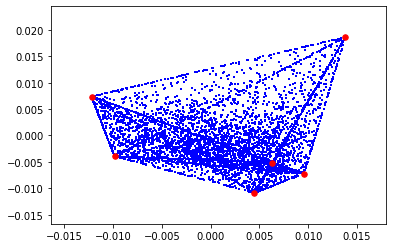

In [18]:
print("recovered anchor words in true Cbar")
vis_extremal_pca(Cbar_proj_true, Snmf, which_dim)
print("true anchor words in est Cbar")
vis_extremal_pca(Cnmf_bar_pj, Strue, which_dim)
print("recovered anchor words in est Cbar")
vis_extremal_pca(Cnmf_bar_pj, Snmf, which_dim)